# Roocs data stores

Roocs consists of stores which it uses to identify and apply fixes to datasets. This notebook demonstrates the purpose of and how to interact with the Character store and the Fix store.

The Character store contains information about the 'character' of datasets that have been scanned. This is used in the identification of fixes.
    
The Fix store keeps track of these fixes. Each document corresponds to a specific dataset and details the fixes which are to be applied to it before an operation is applied to it.

The workflow from scanning datasets to applying fixes is shown below:

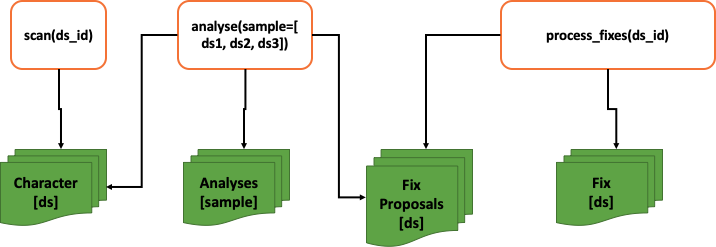

1. Datasets are scanned and the documents are indexed in the Character Store.
2. The analysis is run over samples (collections of datasets). The inputs and results of this are recorded in the Analysis Store.
3. Fix proposals are generated based on any anomalies identified in the analysis of the sample. These are stored in the Fix Proposal Store.
4. The fixes are processed - we decide whether a fix is published to the Fix Store or rejected. If a fix is published it will be applied when a dataset is used in a process (subset, average etc.).

The stores can be accessed through dachar or directly using CEDA Elasticsearch tools.

## Setting up elasticsearch 

In [5]:
# Import the required packages
import virtualenv
import pip
import os

# Define and create the base directory install virtual environments
venvs_dir = os.path.join(os.path.expanduser("~"), "nb-venvs")

if not os.path.isdir(venvs_dir):
    os.makedirs(venvs_dir)
    
# Define the venv directory
venv_dir = os.path.join(venvs_dir, 'venv-dachar-notebook')

In [6]:
# Create the virtual environment
virtualenv.create_environment(venv_dir)

copying /opt/jaspy/bin/python => /home/users/esmith88/nb-venvs/venv-dachar-notebook/bin/python


In [7]:
# Activate the venv
activate_file = os.path.join(venv_dir, "bin", "activate_this.py")
exec(open(activate_file).read(), dict(__file__=activate_file))

In [8]:
# pip install a package using the venv as a prefix
#pip.main(["install", "--prefix", venv_dir, "xarray>=0.15"])
#pip.main(["install", "--prefix",venv_dir, "-e", "git+https://github.com/roocs/dachar.git@dev-elle#egg=dachar"])

!pip install --upgrade pip
!pip install git+https://github.com/roocs/dachar.git@dev-elle

# !git clone https://github.com/roocs/dachar.git
# !pip install -e dachar

Traceback (most recent call last):
  File "/home/users/esmith88/nb-venvs/venv-dachar-notebook/bin/pip", line 7, in <module>
    from pip._internal import main
  File "/home/users/esmith88/nb-venvs/venv-dachar-notebook/lib/python3.7/site-packages/pip/_internal/__init__.py", line 42, in <module>
    from pip._internal import cmdoptions
  File "/home/users/esmith88/nb-venvs/venv-dachar-notebook/lib/python3.7/site-packages/pip/_internal/cmdoptions.py", line 16, in <module>
    from pip._internal.index import (
ImportError: cannot import name 'FormatControl' from 'pip._internal.index' (/home/users/esmith88/nb-venvs/venv-dachar-notebook/lib/python3.7/site-packages/pip/_internal/index/__init__.py)
Traceback (most recent call last):
  File "/home/users/esmith88/nb-venvs/venv-dachar-notebook/bin/pip", line 7, in <module>
    from pip._internal import main
  File "/home/users/esmith88/nb-venvs/venv-dachar-notebook/lib/python3.7/site-packages/pip/_internal/__init__.py", line 42, in <module>
    f

In [9]:
import dachar

char_store = dachar.utils.get_stores.get_dc_store('elasticsearch')
fix_store = dachar.utils.get_stores.get_fix_store('elasticsearch')

## Working with the character store

In [10]:
import pprint

# Use get to get a document by id - the id used is the drs id
# An example drs_id would be cmip5.output1.CCCma.CanCM4.rcp45.mon.ocean.Omon.r1i1p1.latest.zostoga

# Use the get function to return the contents of the document 
doc = char_store.get('cmip5.output1.CCCma.CanCM4.rcp45.mon.ocean.Omon.r1i1p1.latest.zostoga')
print('doc=') 
pprint.pprint(doc)

# To get all documents
all = [_ for _ in char_store.get_all()]
print(len(all))

# To get all drs_ids
[print(_) for _ in char_store.get_all_ids()]

doc=
{'coordinates': {'time': {'axis': 'T',
                          'bounds': 'time_bnds',
                          'calendar': 'noleap',
                          'id': 'time',
                          'length': 360,
                          'long_name': 'time',
                          'max': '2035-12-16T12:00:00',
                          'min': '2006-01-16T12:00:00',
                          'standard_name': 'time'}},
 'data': {'dim_names': ['time'],
          'max': 0.024897083640098572,
          'min': -0.025692744180560112,
          'rank': 1,
          'shape': [360]},
 'dataset_id': 'cmip5.output1.CCCma.CanCM4.rcp45.mon.ocean.Omon.r1i1p1.latest.zostoga',
 'global_attrs': {'CCCma_data_licence': '1) GRANT OF LICENCE - The Government '
                                        'of Canada (Environment Canada) is '
                                        'the \n'
                                        'owner of all intellectual property '
                                  

KeyError: 'ds_id'

The search function allows you to search stores and takes inputs to help you refine your search.
- term - the term to search.
- exact - if false searches for the term as a substring. This only works with case insesitivity for one word search terms. It defaults to false unless searching a number field (which must have exact=True). 
- match_ids - searches drs ids as well if True. Defaults to true.
- fields - the fields to search. For elasticsearch a nested field must be specified or it will not be searched. Defaults to None.

In [ ]:
# Here are some examples of using the search function

print('Successful searches')
# These searches will return a result
res = char_store.search("noleap", exact=True, fields=["coordinates.time.calendar"])
print(len(res))

# The search is changed to exact = True as searching a number field
res = char_store.search(1, exact=True, fields=["data.rank"])
print(len(res))

res = char_store.search("gregorian", exact=False, fields=["coordinates.time.calendar"])
print(len(res))

# in documents the phrase is Max Planck - this search is case insensitive
res = char_store.search("max", exact=False, fields=["global_attrs.institution"])
print(len(res))

# This works as a wildcard match as the correct case is used
res = char_store.search("Max Pla", exact=False, fields=["global_attrs.institution"])
print(len(res))

# example of searching dataset_id
res = char_store.search("MOHC", match_ids=True, exact=False)
print(len(res))

print('-------------------')
print('Failed searches')
# This searches will not return a result 

# Fails because the field has not been specified - need to specify fields=["coordinates.time.calendar"]
res = char_store.search("noleap", exact=True, fields=["coordinates"])
print(len(res))

# Trying to do a wildcard number search - returns 0 because wildcard matching not available for number fields so I don't find what I'm looking for.
res = char_store.search(69, exact=False, fields=["data.min"])
print(len(res))

# Fails as trying to do a wildcard search on a phrase without using the correct case
res = char_store.search("max pla", exact=False, fields=["global_attrs.institution"])
print(len(res))

## Working with the fix store 

You can interact with the fix store in the same way:

In [ ]:
# Use the get function to return the contents of the document 
doc = fix_store.get('cmip5.output1.INM.inmcm4.rcp45.mon.ocean.Omon.r1i1p1.latest.zostoga')
print('doc=')
pprint.pprint(doc)

# To get all documents
all = [_ for _ in fix_store.get_all()]
print(len(all))

# To get all drs_ids
#[print(_) for _ in fix_store.get_all_ids()]

# A search for all coord fixes
res = fix_store.search("coord_fixes", fields=["fixes.category"])
print('search result=')
pprint.pprint(res)